In [33]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Îç∞Ïù¥ÌÑ∞ ÌååÏùº Í≤ΩÎ°ú ÌôïÏù∏
def check_file(file_path):
    if not os.path.exists(file_path):
        print(f"Warning: {file_path} not found!")
    return file_path

# Îç∞Ïù¥ÌÑ∞ Î°úÎìú
train_path = check_file('train.csv')
test_path = check_file('test.csv')
submission_path = check_file('sample_submission.csv')

train_df = pd.read_csv(train_path) if os.path.exists(train_path) else None
test_df = pd.read_csv(test_path) if os.path.exists(test_path) else None
submission_df = pd.read_csv(submission_path) if os.path.exists(submission_path) else None

if train_df is None or test_df is None:
    raise FileNotFoundError("Train or Test data file is missing. Please check file paths.")

# Í≤∞Ï∏°Ïπò ÌôïÏù∏ Î∞è Ï≤òÎ¶¨
def handle_missing_values(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col].fillna('Missing', inplace=True)  # Î≤îÏ£ºÌòï Î≥ÄÏàò ‚Üí 'Missing' ÎåÄÏ≤¥
        else:
            df[col].fillna(df[col].median(), inplace=True)  # ÏàòÏπòÌòï Î≥ÄÏàò ‚Üí Ï§ëÏïôÍ∞í ÎåÄÏ≤¥
    return df

train_df = handle_missing_values(train_df)
test_df = handle_missing_values(test_df)

# Î≤îÏ£ºÌòï Î≥ÄÏàò Ïù∏ÏΩîÎî© (ÌõàÎ†® & ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú ÎèôÏùºÌïòÍ≤å Ï≤òÎ¶¨)
categorical_features = train_df.select_dtypes(include=['object']).columns

for col in categorical_features:
    lbl = LabelEncoder()
    combined_data = pd.concat([train_df[col], test_df[col]], axis=0)  # Î™®Îì† Îç∞Ïù¥ÌÑ∞Î•º Ìè¨Ìï®ÌïòÏó¨ Ïù∏ÏΩîÎî©
    lbl.fit(combined_data.astype(str))  # ÌõàÎ†® & ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú fit Ï†ÅÏö©
    
    train_df[col] = lbl.transform(train_df[col].astype(str))
    test_df[col] = lbl.transform(test_df[col].astype(str))

# ÌÉÄÍ≤ü Î≥ÄÏàò Î°úÍ∑∏ Î≥ÄÌôò
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

# ÌäπÏÑ± ÏóîÏßÄÎãàÏñ¥ÎßÅ (Í±¥Î¨º ÎÇòÏù¥ Í≥ÑÏÇ∞)
train_df['Age'] = train_df['YrSold'] - train_df['YearBuilt']
test_df['Age'] = test_df['YrSold'] - test_df['YearBuilt']

# ÌäπÏÑ± Î∞è ÌÉÄÍ≤ü Î∂ÑÎ¶¨
X = train_df.drop(columns=['Id', 'SalePrice'])
y = train_df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


/tmp/ipykernel_1618136/534386088.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)  # ÏàòÏπòÌòï Î≥ÄÏàò ‚Üí Ï§ëÏïôÍ∞í ÎåÄÏ≤¥
/tmp/ipykernel_1618136/534386088.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doin

In [34]:
# Îã§Ï§ëÍ≥µÏÑ†ÏÑ± ÌôïÏù∏ (VIF Í≥ÑÏÇ∞)
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data.sort_values(by='VIF', ascending=False)

# VIF Í∞í Í≥ÑÏÇ∞ Î∞è ÎÜíÏùÄ Í∞í Ï†úÍ±∞
vif_result = calculate_vif(X_train)
print("VIF Analysis before feature removal:")
print(vif_result)

# VIFÍ∞Ä ÎÜíÏùÄ Î≥ÄÏàò Ï†úÍ±∞ (Ïòà: VIF > 10Ïù∏ Î≥ÄÏàòÎì§ Ï†úÍ±∞)
high_vif_columns = vif_result[vif_result["VIF"] > 10]["Feature"].tolist()
X_train = X_train.drop(columns=high_vif_columns)
X_test = X_test.drop(columns=high_vif_columns)

# Îã§Ïãú VIF Í≥ÑÏÇ∞
vif_result_after = calculate_vif(X_train)
print("VIF Analysis after feature removal:")
print(vif_result_after)

/opt/anaconda3/envs/house/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF Analysis before feature removal:
         Feature       VIF
33    BsmtFinSF1       inf
35    BsmtFinSF2       inf
37   TotalBsmtSF       inf
36     BsmtUnfSF       inf
44  LowQualFinSF       inf
..           ...       ...
47  BsmtHalfBath  1.329423
69   ScreenPorch  1.308951
74       MiscVal  1.139610
8      Utilities  1.125621
68     3SsnPorch  1.075289

[80 rows x 2 columns]
VIF Analysis after feature removal:
          Feature       VIF
20    FireplaceQu  7.686978
30         MoSold  6.387003
6      Condition1  6.090481
13   BsmtExposure  5.751129
12     Foundation  5.543076
5    Neighborhood  5.424948
8      HouseStyle  4.837335
10       RoofMatl  4.763685
3       LotConfig  4.422734
22   GarageFinish  4.393715
9       RoofStyle  4.215561
14   BsmtFinType1  4.056713
21     GarageType  3.443258
1        LotShape  3.348405
0         LotArea  3.026169
19     Fireplaces  2.556206
16   BsmtFullBath  2.418557
15      HeatingQC  2.349101
18       HalfBath  2.209101
23     WoodDeckSF  1

In [35]:
# Î™®Îç∏ ÌïôÏäµ Î∞è ÌèâÍ∞Ä
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

# Î™®Îç∏ Î¶¨Ïä§Ìä∏
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42)
}

# Î™®Îç∏Î≥Ñ RMSE ÌèâÍ∞Ä
for name, model in models.items():
    rmse = evaluate_model(model, X_train, y_train, X_test, y_test)
    print(f'{name} RMSE: {rmse:.4f}')

Linear Regression RMSE: 0.2440
Random Forest RMSE: 0.2136
XGBoost RMSE: 0.2156


In [36]:
# ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÌäúÎãù (GridSearchCV)
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
gs_xgb = GridSearchCV(XGBRegressor(random_state=42), param_grid, cv=kfold, scoring='neg_root_mean_squared_error', verbose=1)
gs_xgb.fit(X_train, y_train)

best_xgb = gs_xgb.best_estimator_
print(f'Best XGBoost RMSE: {evaluate_model(best_xgb, X_train, y_train, X_test, y_test):.4f}')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best XGBoost RMSE: 0.2014


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb

# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞ ÌôïÏù∏
print(f"‚úÖ ÏõêÎ≥∏ ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: {test_df.shape}")

# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Ïª¨Îüº ÏàúÏÑú Î∞è Îç∞Ïù¥ÌÑ∞ ÌÉÄÏûÖ ÌôïÏù∏
X_test = test_df.drop(columns=['Id'])  # 'Id' Ïª¨Îüº Ï†úÍ±∞
X_test = X_test.astype(np.float64)  # Î™®Îì† Îç∞Ïù¥ÌÑ∞Î•º float64Î°ú Î≥ÄÌôò
X_test = X_test[best_xgb.feature_names_in_]  # Ïª¨Îüº ÏàúÏÑú ÎßûÏ∂îÍ∏∞

# ÏµúÏ¢Ö ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞ ÌôïÏù∏
print(f"‚úÖ Î≥ÄÌôò ÌõÑ ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: {X_test.shape}")

# ÏòàÏ∏° Ïã§Ìñâ
y_pred = best_xgb.predict(X_test)
print(f"‚úÖ ÏµúÏ¢Ö ÏòàÏ∏°Í∞í ÌÅ¨Í∏∞: {y_pred.shape}")  # (1459,) ÌôïÏù∏

# CSV Ï†ÄÏû•
submission = pd.DataFrame({"Id": test_df["Id"], "SalePrice": np.expm1(y_pred)})
submission.to_csv("submission.csv", index=False)

print("‚úÖ Kaggle Ï†úÏ∂ú ÌååÏùºÏù¥ ÏÉùÏÑ±ÎêòÏóàÏäµÎãàÎã§: submission.csv")


üö® ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Ïóê ÏóÜÎäî Ïª¨Îüº: set()
üö® ÌõàÎ†® Îç∞Ïù¥ÌÑ∞Ïóê ÏóÜÎäî Ïª¨Îüº: set()
‚úÖ ÏµúÏ¢Ö ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Ïª¨Îüº: ['LotArea', 'LotShape', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrArea', 'Foundation', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold']
‚úÖ ÏµúÏ¢Ö ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ dtype: [dtype('float64')]
‚úÖ ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: (292, 31)
‚úÖ ÏòàÏ∏°Í∞í ÌÅ¨Í∏∞: (292,)


ValueError: array length 292 does not match index length 1459

In [43]:
# 1Ô∏è‚É£ DataFrame Ïú†ÏßÄ
if isinstance(X_test, np.ndarray):
    X_test = pd.DataFrame(X_test, columns=best_xgb.feature_names_in_)

# 2Ô∏è‚É£ Îç∞Ïù¥ÌÑ∞ ÌÉÄÏûÖ Î≥ÄÌôò (Î™®Îì† Ïª¨ÎüºÏùÑ float64Î°ú ÌÜµÏùº)
X_test = X_test.astype(np.float64)

# 3Ô∏è‚É£ Î™®Îç∏Ïù¥ ÌïôÏäµÌïú Ïª¨Îüº ÏàúÏÑúÎåÄÎ°ú Ï†ïÎ†¨
X_test = X_test[best_xgb.feature_names_in_]

# 4Ô∏è‚É£ ÏµúÏ¢ÖÏ†ÅÏúºÎ°ú Ïª¨ÎüºÍ≥º Îç∞Ïù¥ÌÑ∞ ÌÉÄÏûÖ ÌôïÏù∏
print("‚úÖ ÏµúÏ¢Ö ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Ïª¨Îüº:", X_test.columns.tolist())
print("‚úÖ ÏµúÏ¢Ö ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ dtype:", X_test.dtypes.unique())

# 5Ô∏è‚É£ ÏòàÏ∏° Ïã§Ìñâ
y_pred = best_xgb.predict(X_test)

‚úÖ ÏµúÏ¢Ö ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Ïª¨Îüº: ['LotArea', 'LotShape', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrArea', 'Foundation', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold']
‚úÖ ÏµúÏ¢Ö ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ dtype: [dtype('float64')]


In [44]:
# ÏµúÏ¢Ö ÏòàÏ∏° Ïã§Ìñâ
y_pred = best_xgb.predict(X_test)

In [46]:
# Kaggle Ï†úÏ∂úÏùÑ ÏúÑÌïú Ìï®Ïàò
def create_submission(model, X_test, test_df, model_name):
    """ ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌïú ÏòàÏ∏°ÏùÑ ÏàòÌñâÌïòÍ≥† Kaggle Ï†úÏ∂ú ÌååÏùº ÏÉùÏÑ± """
    y_pred = model.predict(X_test)  # ÏòàÏ∏°Í∞í ÏÉùÏÑ±

    # Î°úÍ∑∏ Î≥ÄÌôòÏùÑ ÎêòÎèåÎ¶¨Í∏∞ (expm1)
    y_pred = np.expm1(y_pred)

    # Ï†úÏ∂ú ÌååÏùº ÏÉùÏÑ±
    submission = pd.DataFrame({"Id": test_df["Id"], "SalePrice": np.expm1(y_pred)})  # Î°úÍ∑∏ Î≥ÄÌôò Ìï¥Ï†ú
    submission.to_csv("submission2.csv", index=False)  # CSV ÌååÏùº Ï†ÄÏû•

    print("‚úÖ Kaggle Ï†úÏ∂ú ÌååÏùºÏù¥ ÏÉùÏÑ±ÎêòÏóàÏäµÎãàÎã§: submission.csv")

# Í∞ÄÏû• ÏÑ±Îä•Ïù¥ Ï¢ãÏùÄ Î™®Îç∏ÏùÑ ÏÑ†ÌÉùÌïòÏó¨ Ï†úÏ∂ú ÌååÏùº ÏÉùÏÑ±
best_model = best_xgb  # RMSE ÌôïÏù∏ ÌõÑ Í∞ÄÏû• ÏÑ±Îä• Ï¢ãÏùÄ Î™®Îç∏ ÏÑ†ÌÉù
create_submission(best_model, test_df.drop(columns=['Id']), test_df, "XGBoost")

ValueError: feature_names mismatch: ['LotArea', 'LotShape', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrArea', 'Foundation', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold'] ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'Age']
training data did not have the following fields: BsmtQual, LandContour, BsmtCond, 1stFlrSF, Fence, Age, OverallQual, MiscFeature, GarageCond, GarageYrBlt, YearRemodAdd, FullBath, GarageArea, MSSubClass, SaleType, BsmtFinSF1, Condition2, ExterQual, MasVnrType, KitchenQual, Street, GrLivArea, PavedDrive, KitchenAbvGr, YrSold, Alley, OverallCond, ExterCond, Electrical, BsmtUnfSF, MSZoning, TotRmsAbvGrd, BsmtFinType2, Heating, TotalBsmtSF, PoolQC, YearBuilt, CentralAir, GarageCars, SaleCondition, BsmtFinSF2, 2ndFlrSF, Functional, Exterior2nd, LowQualFinSF, BedroomAbvGr, GarageQual, Exterior1st, LotFrontage

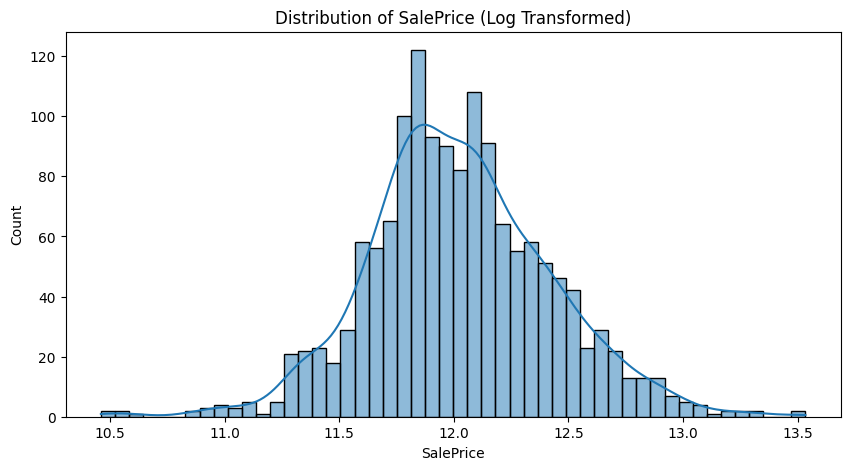

In [10]:
# Í≤∞Í≥º ÏãúÍ∞ÅÌôî (SalePrice Î∂ÑÌè¨ ÌôïÏù∏)
plt.figure(figsize=(10,5))
sns.histplot(train_df['SalePrice'], kde=True, bins=50)
plt.title('Distribution of SalePrice (Log Transformed)')
plt.show()